<a href="https://colab.research.google.com/github/mitkrieg/dl-assignment-1/blob/main/assignment1_practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: DL Basics

### Goal
Implement [LeNet5](https://arxiv.org/pdf/1502.03167v3) and compare various regularization techniques on the network using the FashionMNSIT dataset.

## Library Imports

In [1]:
!pip install wandb
!wandb login

wandb: Currently logged in as: mitkrieger (mitkrieger-cornell-university). Use `wandb login --relogin` to force relogin


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import gzip
import typing as T
import wandb

drive.mount('/content/drive')
torch.manual_seed(123)

wandb.init(project='DL_Assignment_1')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


wandb: Currently logged in as: mitkrieger (mitkrieger-cornell-university). Use `wandb login --relogin` to force relogin


## Check for GPU Access

In [4]:
print("------ ACCELERATION INFO -----")
print('GPU Available:',torch.cuda.is_available())
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('GPU Name:',torch.cuda.get_device_name(0))
  print('GPU Count:',torch.cuda.device_count())
  print('GPU Memory Allocated:',torch.cuda.memory_allocated(0))
  print('GPU Memory Cached:',torch.cuda.memory_reserved(0))
else:
  device = torch.device('cpu')
  print('Using CPU')

------ ACCELERATION INFO -----
GPU Available: False
Using CPU


## Load Data using Pytorch

In [ ]:

PATH = '/content/drive/MyDrive/Fall 2024/Deep Learning/Assignment 1/data'


### Define FashionMNIST

In [ ]:
class FasionMNISTDataset(Dataset):
  def __init__(self, path: str, kind: str, transform=None, target_transform=None, device=None) -> None:
    self.transform = transform
    self.target_transform = target_transform
    self.device = device
    self.labels, self.images = self._load_data(path, kind)

  def _load_data(self, path: str, kind: str) -> T.Tuple[np.ndarray, np.ndarray]:
    with gzip.open(path + f'/{kind}-labels-idx1-ubyte.gz', 'rb') as lable_file:
      lbls = np.frombuffer(lable_file.read(), dtype=np.int8, offset=8)
      lbls = np.copy(lbls)
    with gzip.open(path + f'/{kind}-images-idx3-ubyte.gz', 'rb') as lable_file:
      imgs = np.frombuffer(lable_file.read(), dtype=np.uint8, offset=16).reshape(len(lbls), 1, 28, 28)
      imgs = (np.copy(imgs) / 255).astype(np.float32)
    return lbls, imgs

  def __len__(self) -> int:
    return self.labels.size

  def __getitem__(self, index: int) -> T.Tuple[torch.tensor, torch.tensor]:
    label = torch.tensor(self.labels[index], dtype=torch.long)
    img = torch.tensor(self.images[index])
    if self.device:
      img = img.to(self.device)
      label = label.to(self.device)
    if self.target_transform:
      label = self.target_transform(label)
    if self.transform:
      img = self.transform(img)


    return img, label

def show_img(dataset: Dataset, index: int) -> None:
  img, label = dataset[index]
  labels_map = {
            0: "T-Shirt",
            1: "Trouser",
            2: "Pullover",
            3: "Dress",
            4: "Coat",
            5: "Sandal",
            6: "Shirt",
            7: "Sneaker",
            8: "Bag",
            9: "Ankle Boot",
        }
  plt.imshow(img.cpu().reshape(28,28), cmap='gray')
  plt.title(labels_map[label.cpu().item()])
  plt.show()

### Create Train, Validation and Test sets with loaders

In [ ]:
gen = torch.Generator().manual_seed(123)

train = FasionMNISTDataset(PATH, 'train', device=device)
train, val = torch.utils.data.random_split(train, [0.8, 0.2], generator=gen)
test = FasionMNISTDataset(PATH, 'test', device=device)

batch = 128
trainloader = DataLoader(train, batch, shuffle=True, generator=gen)
valloader = DataLoader(val, batch, shuffle=True, generator=gen)
testloader = DataLoader(test, batch, shuffle=True, generator=gen)

dataloaders = {
    'train': trainloader,
    'val': valloader,
    'test': testloader
}

#### Example Image

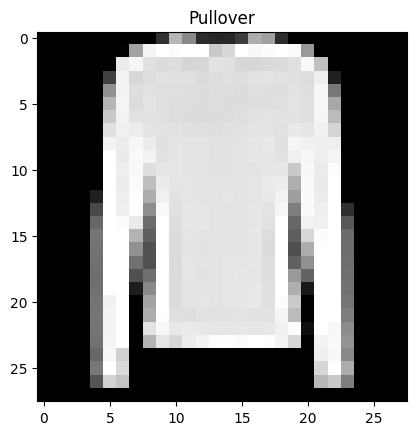

In [ ]:
show_img(train, 0)

## LeNet5

In [ ]:
class Lenet5(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
    self.max_pool1 = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.max_pool2 = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(16*4*4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84,10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.max_pool1(x)
    x = F.relu(self.conv2(x))
    x = self.max_pool2(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Lenet5()
net.to(device)

cross_entropy = nn.CrossEntropyLoss()
sgd = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)

### Define Training Loop & train LeNet5

In [ ]:
def train_epoch(network, dataloader, loss_fn, optimizer, device, epoch, verbosity: int):
  network.train()
  batch_loss = 0
  total_loss = 0
  for i, data in enumerate(dataloader):
    inputs, labels = data

    optimizer.zero_grad()
    outputs = network(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    batch_loss += loss.item()
    if i % verbosity == verbosity - 1:
      print(f'Batch #{i + 1} Loss: {batch_loss / verbosity}')
      batch_loss = 0

  print(f'\033[92mEpoch #{epoch + 1} Total Loss: {total_loss / len(dataloader)}\033[0m')
  total_loss = 0

def eval_network(title, network, dataloader, loss_fn):
  network.eval()
  correct = 0
  total = 0
  loss = 0

  with torch.no_grad():
      for data in dataloader:
          images, labels = data
          outputs = network(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      wandb.log({
          f'{title}-loss': loss / len(dataloader),
          f'{title}-accuracy': correct / total
      })

  print(f'{title} accuracy: {correct}/{total} = {100 * correct / total : .4} % ||| loss {loss / len(dataloader)}')

def train_network(network, dataloaders, loss_fn, optimizer, device, epochs: int, verbosity: int):
  for epoch in range(epochs):
    print(f'----------- Epoch #{epoch + 1} ------------')
    train_epoch(network, dataloaders['train'], loss_fn, optimizer, device, epoch, verbosity)
    eval_network('Train', network, dataloaders['train'], loss_fn)
    eval_network('Validation', network, dataloaders['val'], loss_fn)
    eval_network('Test', network, dataloaders['test'], loss_fn)
    print('------------------------------------\n')

train_network(net, dataloaders, cross_entropy, sgd, device, 10, 100)

# eval_network('Train', net, trainloader)
# eval_network('Validation', net, valloader)
# eval_network('Test', net, valloader)


----------- Epoch #1 ------------
Batch #100 Loss: 2.1476374006271364
Batch #200 Loss: 1.0365534168481827
Batch #300 Loss: 0.7561711609363556
Epoch #1 Total Loss: 1.1873653337160746
Train accuracy: 35713/48000 =  74.4 %
Validation accuracy: 8891/12000 =  74.09 %
Test accuracy: 7365/10000 =  73.65 %
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.6544040343165398
Batch #200 Loss: 0.6067728072404861
Batch #300 Loss: 0.5736526721715927
Epoch #2 Total Loss: 0.600652069568634
Train accuracy: 38415/48000 =  80.03 %
Validation accuracy: 9648/12000 =  80.4 %
Test accuracy: 7907/10000 =  79.07 %
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.5370047271251679
Batch #200 Loss: 0.504536963403225
Batch #300 Loss: 0.4734526482224464
Epoch #3 Total Loss: 0.5033453831672668
Train accuracy: 39786/48000 =  82.89 %
Validation accuracy: 10019/12000 =  83.49 %
Test accuracy: 8201/10000 =  82.01 %
------------------------

### Variations on LeNet5

#### Using Batch Normalization

In [ ]:
class Lenet5BN(Lenet5):
    def __init__(self):
        super().__init__()
        self.BN1 = nn.BatchNorm2d(6)
        self.BN2 = nn.BatchNorm2d(16)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.BN1(x))
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(self.BN2(x))
        x = self.max_pool2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net_bn = Lenet5BN()
net_bn.to(device)

cross_entropy = nn.CrossEntropyLoss()
sgd = optim.SGD(net_bn.parameters(), lr=1e-2, momentum=0.9)

train_network(net_bn, trainloader, cross_entropy, sgd, device, 5, 100)
print('Train ', end=' ')
eval_network(net_bn, trainloader)
print('Val ', end=' ')
eval_network(net_bn, valloader)

Epoch #1, Batch #100: 1.3038415053486825
Epoch #1, Batch #200: 0.5852211400866508
Epoch #1, Batch #300: 0.4887618997693062
Epoch #2, Batch #100: 0.41760692834854124
Epoch #2, Batch #200: 0.39652421697974205
Epoch #2, Batch #300: 0.3763559329509735
Epoch #3, Batch #100: 0.3489046224951744
Epoch #3, Batch #200: 0.34393509075045586
Epoch #3, Batch #300: 0.3283694978058338
Epoch #4, Batch #100: 0.3054264672100544
Epoch #4, Batch #200: 0.3263666643202305
Epoch #4, Batch #300: 0.3100899827480316
Epoch #5, Batch #100: 0.2936034318804741
Epoch #5, Batch #200: 0.2958679489791393
Epoch #5, Batch #300: 0.2838006091117859
Done!
Train  accuracy of the network: 43342/48000 =  90.3 %
Val  accuracy of the network: 10674/12000 =  88.95 %


#### Using Dropout

In [ ]:
class Lenet5Dropout(Lenet5):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
net_drop = Lenet5Dropout()
net_drop.to(device)

cross_entropy = nn.CrossEntropyLoss()
sgd = optim.SGD(net_drop.parameters(), lr=1e-2, momentum=0.9)

train_network(net_drop, trainloader, cross_entropy, sgd, device, 5, 100)
print('Train ', end=' ')
eval_network(net_drop, trainloader)
print('Val ', end=' ')
eval_network(net_drop, valloader)

Epoch #1, Batch #100: 2.128076936006546
Epoch #1, Batch #200: 1.1122429305315018
Epoch #1, Batch #300: 0.9347625380754471
Epoch #2, Batch #100: 0.7302924126386643
Epoch #2, Batch #200: 0.7162318629026413
Epoch #2, Batch #300: 0.6619235336780548
Epoch #3, Batch #100: 0.6110357031226158
Epoch #3, Batch #200: 0.5920484709739685
Epoch #3, Batch #300: 0.5700480201840401
Epoch #4, Batch #100: 0.5539535850286483
Epoch #4, Batch #200: 0.5363448470830917
Epoch #4, Batch #300: 0.5169841501116753
Epoch #5, Batch #100: 0.4909411099553108
Epoch #5, Batch #200: 0.4942573729157448
Epoch #5, Batch #300: 0.48635844796895983
Done!
Train  accuracy of the network: 40412/48000 =  84.19 %
Val  accuracy of the network: 10090/12000 =  84.08 %


#### Using Weight Decay

In [ ]:
net_decay = Lenet5()
net_decay.to(device)

cross_entropy = nn.CrossEntropyLoss()
sgd = optim.SGD(net_decay.parameters(), lr=1e-2, momentum=0.9, weight_decay=0.001)

train_network(net_decay, trainloader, cross_entropy, sgd, device, 5, 100)
print('Train ', end=' ')
eval_network(net_decay, trainloader)
print('Val ', end=' ')
eval_network(net_decay, valloader)

Epoch #1, Batch #100: 2.2974420762062073
Epoch #1, Batch #200: 1.8504662150144577
Epoch #1, Batch #300: 0.849350825548172
Epoch #2, Batch #100: 0.630090397298336
Epoch #2, Batch #200: 0.5989323544502259
Epoch #2, Batch #300: 0.56491309851408
Epoch #3, Batch #100: 0.5215689361095428
Epoch #3, Batch #200: 0.5109328374266624
Epoch #3, Batch #300: 0.48035361170768737
Epoch #4, Batch #100: 0.4602187183499336
Epoch #4, Batch #200: 0.4552498507499695
Epoch #4, Batch #300: 0.42894158005714417
Epoch #5, Batch #100: 0.40615937143564224
Epoch #5, Batch #200: 0.41247298181056974
Epoch #5, Batch #300: 0.4040353463590145
Done!
Train  accuracy of the network: 41364/48000 =  86.17 %
Val  accuracy of the network: 10291/12000 =  85.76 %
